# Seasonality of NDVI across Australia




In [1]:
import sys
import folium
import warnings
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import xarray as xr
from scipy import stats
import contextily as ctx
import numpy as np
import scipy.signal
import contextily as ctx
import matplotlib.pyplot as plt
from xarrayMannKendall import Mann_Kendall_test

import odc.geo.xr
from odc.geo.geobox import zoom_out
from odc.geo.xr import assign_crs

sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords

sys.path.append('/g/data/os22/chad_tmp/dea-notebooks/Tools/')
from dea_tools.spatial import xr_rasterize
from dea_tools.temporal import xr_phenology

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Analysis Parameters


In [2]:
var='NDVI'
ds_path = '/g/data/os22/chad_tmp/AusENDVI/data/NDVI_harmonization/LGBM/NDVI_CLIM_LGBM_5km_monthly_1982_2022_noGaps.nc'
chunks=None#dict(latitude=1000, longitude=1000, time=-1)
t_range='1982', '2022'

## Open data

In [3]:
ds = assign_crs(xr.open_dataset(ds_path, chunks=chunks)[var], crs='EPSG:4326')
ds = ds.sel(time=slice(t_range[0], t_range[1]))

if var=='NDVI':
    ds = ds.rename({'latitude':'y', 'longitude':'x'})

## Smoothing filters

In [4]:
ds_up = ds.resample(time="2W").interpolate("linear")

# # Savitsky-Golay
ds_smooth = xr.apply_ufunc(
        scipy.signal.savgol_filter,
        ds_up,
        input_core_dims=[['time']],
        output_core_dims=[['time']],
        kwargs=dict(
            window_length=11,
            polyorder=3,
            deriv=0,
            mode='interp'),
        dask='allowed'
    )
#SG cuts of last 6 months so clip to complete calendar years.
ds_smooth = ds_smooth.sel(time=slice('1982', '2021'))

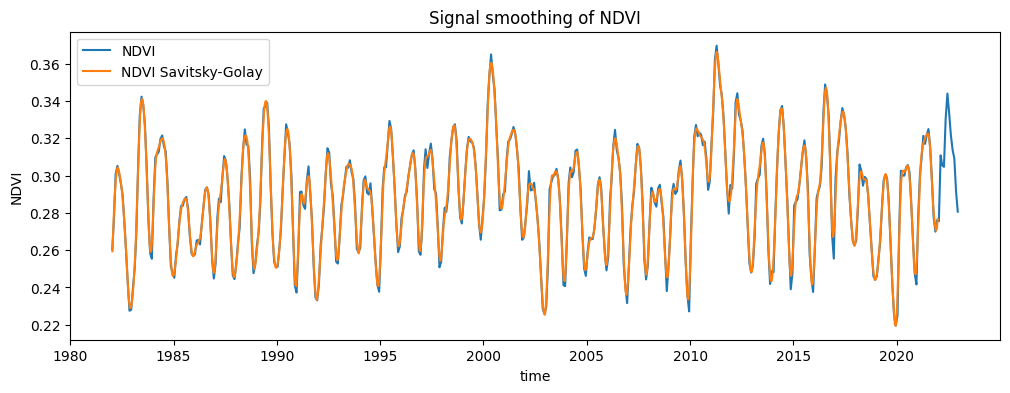

In [5]:
fig,ax=plt.subplots(1,1, figsize=(12,4))
ds.mean(['x', 'y']).plot(ax=ax, label='NDVI')
# ds_up.mean(['x', 'y']).plot(ax=ax, label='NDVI-up')
ds_smooth.mean(['x', 'y']).plot(ax=ax, label='NDVI Savitsky-Golay')
# ds_smooth_rolling.mean(['x', 'y']).plot(ax=ax, label='NDVI rolling')
ax.legend(loc='upper left')
ax.set_title('Signal smoothing of NDVI');

## Create a mask for non-seasonal regions

To avoid applying phenology trend analysis on regions that do not experience regular seasonal variation, we will create a mask that removes areas designated as 'non-seasonal'. We use [Moore et al. 2016.](https://bg.copernicus.org/articles/13/5085/2016/) as a guide here ("non-seasonally dynamic": EVI varies but not in accordance with seasons), the thresholds needed to create the mask will be somewhat arbitrary but we will attempt to delineate areas with 1. low seasonal variability and low NDVI, and 2. areas with low seasonal variability and high interannual variability.

Process:
1. Calculate seasonally-adjusted anomalies
2. Calcuate standard deviation in anomalies
3. Overall mean NDVI
4. Standard deviation of the mean seasonal pattern.


In [6]:
import warnings
warnings.simplefilter('ignore')

#standardized anom
def anomalies(ds):
    return xr.apply_ufunc(
        lambda x, m: (x - m),
            ds.groupby("time.month"),
            ds.groupby("time.month").mean()
    )

# 3. Mean NDVI
mean_ndvi = ds_smooth.mean('time')

##Mask very low NDVI (get rid of remnant water etc.)
low_ndvi_mask = xr.where(mean_ndvi<0.115,0, 1)
mean_ndvi = mean_ndvi.where(low_ndvi_mask)
    
# 1. calculate anomalies
ndvi_std_anom = anomalies(ds_smooth)
# 2. std dev in anomalies
anom_std = ndvi_std_anom.std('time').where(low_ndvi_mask)
# 4. Std deviation of the mean seasonal pattern
std_mean_season = ds.groupby("time.month").mean().std('month').where(low_ndvi_mask)

### Create the mask

In [7]:
low_seasonal_variability_low_ndvi = xr.where((std_mean_season<0.03) & (mean_ndvi<0.3), 1, 0)
low_seasonal_variability_high_anomaly = xr.where((std_mean_season<0.03) &  (anom_std>0.07), 1, 0)

seasonal_mask = xr.where((low_seasonal_variability_low_ndvi) | (low_seasonal_variability_high_anomaly), 0, 1)

#aply the mask
ds_smooth = ds_smooth.where(seasonal_mask)

### Plot

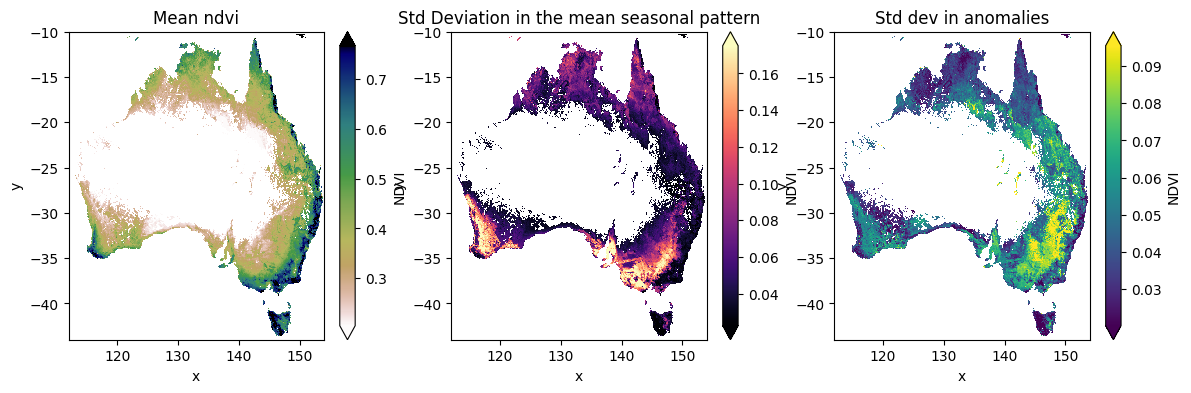

In [8]:
fig,ax=plt.subplots(1,3, figsize=(14,4))
anom_std.where(seasonal_mask).plot.imshow(ax=ax[2], robust=True)
mean_ndvi.where(seasonal_mask).plot.imshow(ax=ax[0], robust=True, cmap='gist_earth_r')
std_mean_season.where(seasonal_mask).plot.imshow(ax=ax[1], robust=True, cmap='magma')
ax[2].set_title('Std dev in anomalies')
ax[0].set_title('Mean ndvi')
ax[1].set_title('Std Deviation in the mean seasonal pattern');

## Calculate annual phenology statistics

In [9]:
warnings.simplefilter('ignore')
doy = ds_smooth.groupby('time.year').map(xr_phenology)

# remask as NaN areas get a phenology value
nan_mask = ~(np.isnan(mean_ndvi))
doy = doy.where(seasonal_mask).where(nan_mask)

In [10]:
# fig,ax=plt.subplots(1,1, figsize=(11,4))
# ax2 = ax.twinx()
# doy.POS.where(doy['POS']>20).mean(['x', 'y']).plot(ax=ax, c='orange', label='POS DOY')
# doy.vPOS.where(doy['POS']>20).mean(['x', 'y']).plot(ax=ax2, c='blue', label='vPOS NDVI')
# ax.legend(loc='upper left')
# ax2.legend(loc='upper right')
# ax.set_title('')
# ax2.set_title('Australia-wide trends in Peak-Of-Season NDVI');

## Per pixel trends in POS

Use the Mann-Kendall robust regression (this is quite slow)

In [11]:
pos_trends = Mann_Kendall_test(doy['POS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

vpos_trends = Mann_Kendall_test(doy['vPOS'].rename({'year':'time'}),
                               alpha=0.05,
                               method='theilslopes'
                              ).compute()

In [12]:
# (pos_trends['trend']*10).plot(vmax=20, vmin=-20, add_labels=False, cmap='coolwarm')

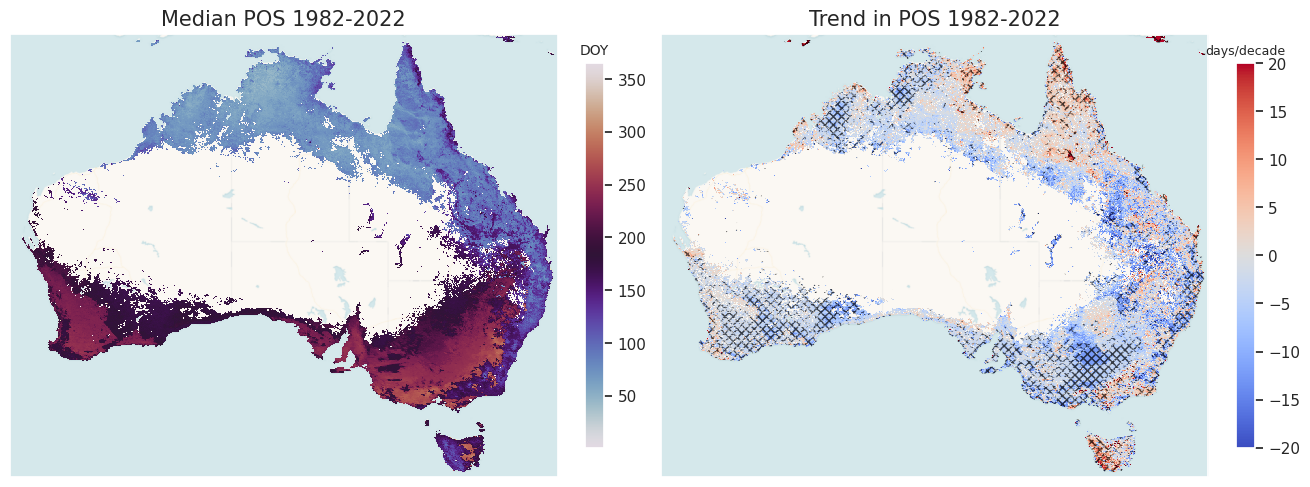

In [13]:
sb.set(font_scale=1.0)
vmin=1
vmax=365
font=15

fig,ax = plt.subplots(1,2, figsize=(13,6), sharex=True, sharey=True, layout='constrained')
for a,i in zip(ax.reshape(-1), range(0,2)):
    if i==0:
        im = doy['POS'].where(doy['POS']>20).median('year').plot(cmap='twilight',
                                    vmin=vmin, vmax=vmax, ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical')
        cb.ax.set_title('DOY', fontsize=10)
        a.set_title('Median POS 1982-2022', fontsize=font)
    
    if i==1:
        t = pos_trends.trend.where(pos_trends.trend!=0.0)
        # t = pos_trends.trend.where(pos_trends.signif)
        im = (t*10).plot(vmax=20, vmin=-20, ax=a, add_labels=False, cmap='coolwarm', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical')
        cb.ax.set_title('days/decade', fontsize=9) #\u207B\u00B9
        
        # xr.plot.contourf(pos_trends.trend.where(pos_trends.signif), ax=a, alpha=0, hatches=['XXXX'], add_colorbar=False)
        # a.contourf(pos_trends.trend.where(pos_trends.signif).data, alpha=1, hatches=['XXXX'])

        #significane plotting (contourf failing??)
        lons, lats = np.meshgrid(t.x, t.y)
        sig_area = np.where(pos_trends.signif == 1)
        a.hexbin(x=lons[sig_area].reshape(-1),
                 y=lats[sig_area].reshape(-1),
                 C=pos_trends.signif.where(pos_trends.signif == 1).data[sig_area].reshape(-1),
                 hatch='XXXX',
                 alpha=0,
                 gridsize=(400,400)
                )
        
        ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('Trend in POS 1982-2022', fontsize=font)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

fig.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/POS_"+var+"_per_pixel_trends.png",
            bbox_inches='tight', dpi=300)


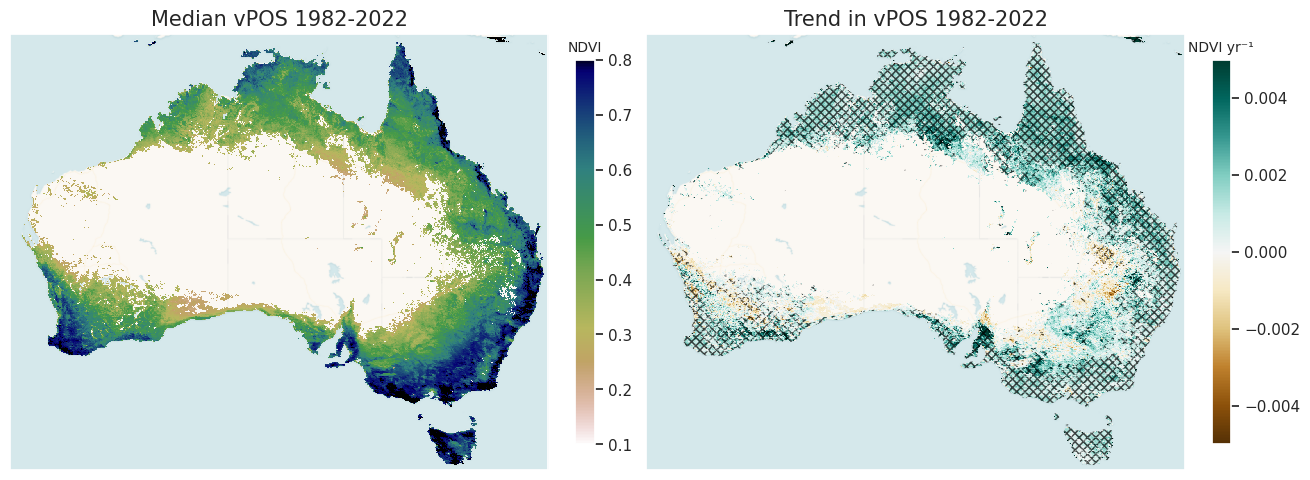

In [14]:
sb.set(font_scale=1.0)
fig,ax = plt.subplots(1,2, figsize=(13,6), sharex=True, sharey=True, layout='constrained')
for a,i in zip(ax.reshape(-1), range(0,2)):
    if i==0:
        im = doy['vPOS'].where(doy['POS']>20).median('year').plot(cmap='gist_earth_r', vmin=0.1, vmax=0.8, 
                                   ax=a, add_labels=False, add_colorbar=False)
        ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels,
                        crs='EPSG:4326', attribution='', attribution_size=1)
        cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical')
        cb.ax.set_title('NDVI', fontsize=10)
        a.set_title('Median vPOS 1982-2022', fontsize=font)
    
    if i==1:
        im = vpos_trends.trend.where(vpos_trends.trend!=0).plot(vmin=-0.005,
                                        vmax=0.005, ax=a, add_labels=False, cmap='BrBG', add_colorbar=False)
        cb = fig.colorbar(im, ax=a, shrink=0.65, orientation='vertical')
        cb.ax.set_title('NDVI yr\u207B\u00B9', fontsize=10)
        # xr.plot.contourf(vpos_trends.trend.where(vpos_trends.signif),
        #                  ax=a, alpha=0, hatches=['XXXX'], add_colorbar=False)

        #significance plotting (contourf failing??)
        lons, lats = np.meshgrid(vpos_trends.x, vpos_trends.y)
        sig_area = np.where(vpos_trends.signif == 1)
        a.hexbin(x=lons[sig_area].reshape(-1),
                 y=lats[sig_area].reshape(-1),
                 C=vpos_trends.signif.where(vpos_trends.signif == 1).data[sig_area].reshape(-1),
                 hatch='XXXX',
                 alpha=0,
                 gridsize=(400,400)
                )
        
        ctx.add_basemap(a, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
        a.set_title('Trend in vPOS 1982-2022', fontsize=font)
    
    a.set_yticklabels([])
    a.set_ylabel('')
    a.set_xlabel('')
    a.set_xticklabels([]);

fig.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/vPOS_"+var+"_per_pixel_trends.png",
            bbox_inches='tight', dpi=300)

## Interactive plots

In [15]:
pos_trends = assign_crs(pos_trends, crs='epsg:4326')
vpos_trends = assign_crs(vpos_trends, crs='epsg:4326')

In [19]:
# pos_trends.trend.where(~np.isnan(mean_ndvi)).odc.explore(vmin=-2,vmax=2,
#                              cmap='coolwarm',
#                             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#                             attr = 'Esri',
#                             name = 'Esri Satellite',
#                             )

In [20]:
# vpos_trends.trend.where(~np.isnan(mean_ndvi)).odc.explore(vmin=-0.005,vmax=0.005,
#                              cmap='BrBG',
#                             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#                             attr = 'Esri',
#                             name = 'Esri Satellite',
#                             )

## Trends in POS & vPOS etc. disaggregrated by bioclimatic region

Two ways to do this:
1. Average phenology metrics over the region, then calculate slopes over the aggregated timeseries.
2. Calculate per pixel slopes, then plot the distribution of slopes in the region.


In [21]:
gdf = gpd.read_file('/g/data/os22/chad_tmp/AusENDVI/data/bioclimatic_regions.geojson')
gdf = gdf[0:5] # drop the desert since we masked 99% of it anyway

#### The first way

In [22]:
doy_var = [doy]
names = [var]

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], ds.isel(time=1))
    mask = round_coords(mask)
    
    if var=='NDVI':
        mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(doy_var, names):
        var_region = v.where(mask)
        
        doy_df = var_region.POS.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        doy_df['vPOS'] = var_region.vPOS.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        
        doy_df['region'] = row['region_name']
        doy_df = doy_df.rename({
            'vPOS':'vPOS ('+var+')',
            'POS':'Peak-Of-Season (DOY)'
                      },   
                      axis=1)
        inner.append(doy_df)
    outer.append(inner)

df=[]
for i in range(0,len(outer)):
    xx = df.append(pd.concat(outer[i]))
df = pd.concat(df)
df = df.reset_index()

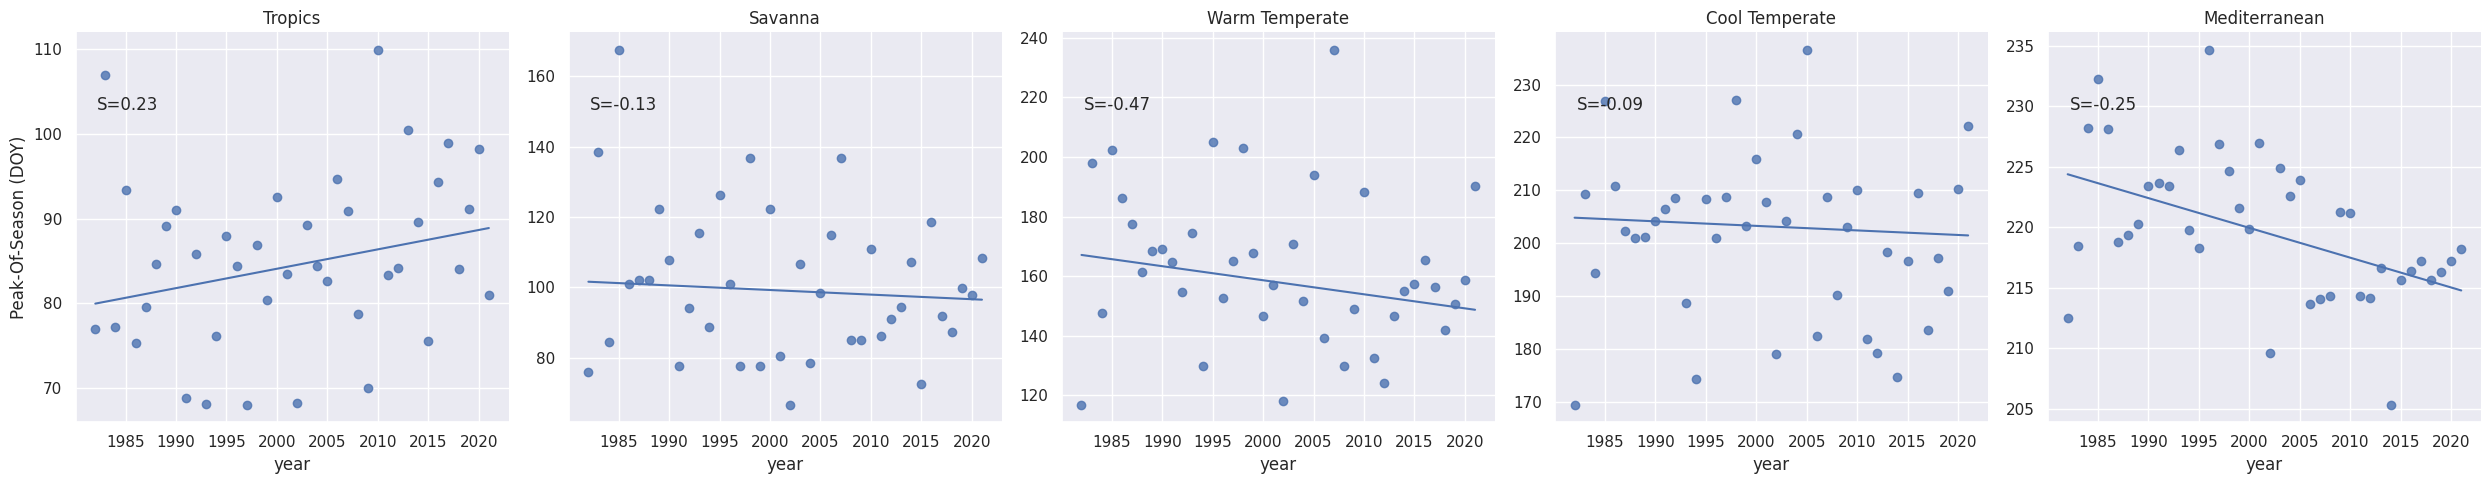

In [23]:
g = sb.lmplot(
    data=df, x="year", y="Peak-Of-Season (DOY)",
    col="region", fit_reg=False, col_wrap=6,
    facet_kws=dict(sharex=True, sharey=False)
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
def annotate(data, **kws):
    # s, i, r, p, se = stats.linregress(data['year'],data['Peak-Of-Season (DOY)'])
    s, i, l, h =  stats.mstats.theilslopes(data['Peak-Of-Season (DOY)'], data['year']) 
    ax = plt.gca()
    ax.plot(data['year'], i + s * data['year'], 'b-')
    # ax.plot(data['year'], i + l * data['year'], 'r--')
    # ax.plot(data['year'], i + h * data['year'], 'r--')
    ax.text(.05, .8, 'S={:.2f}'.format(s),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

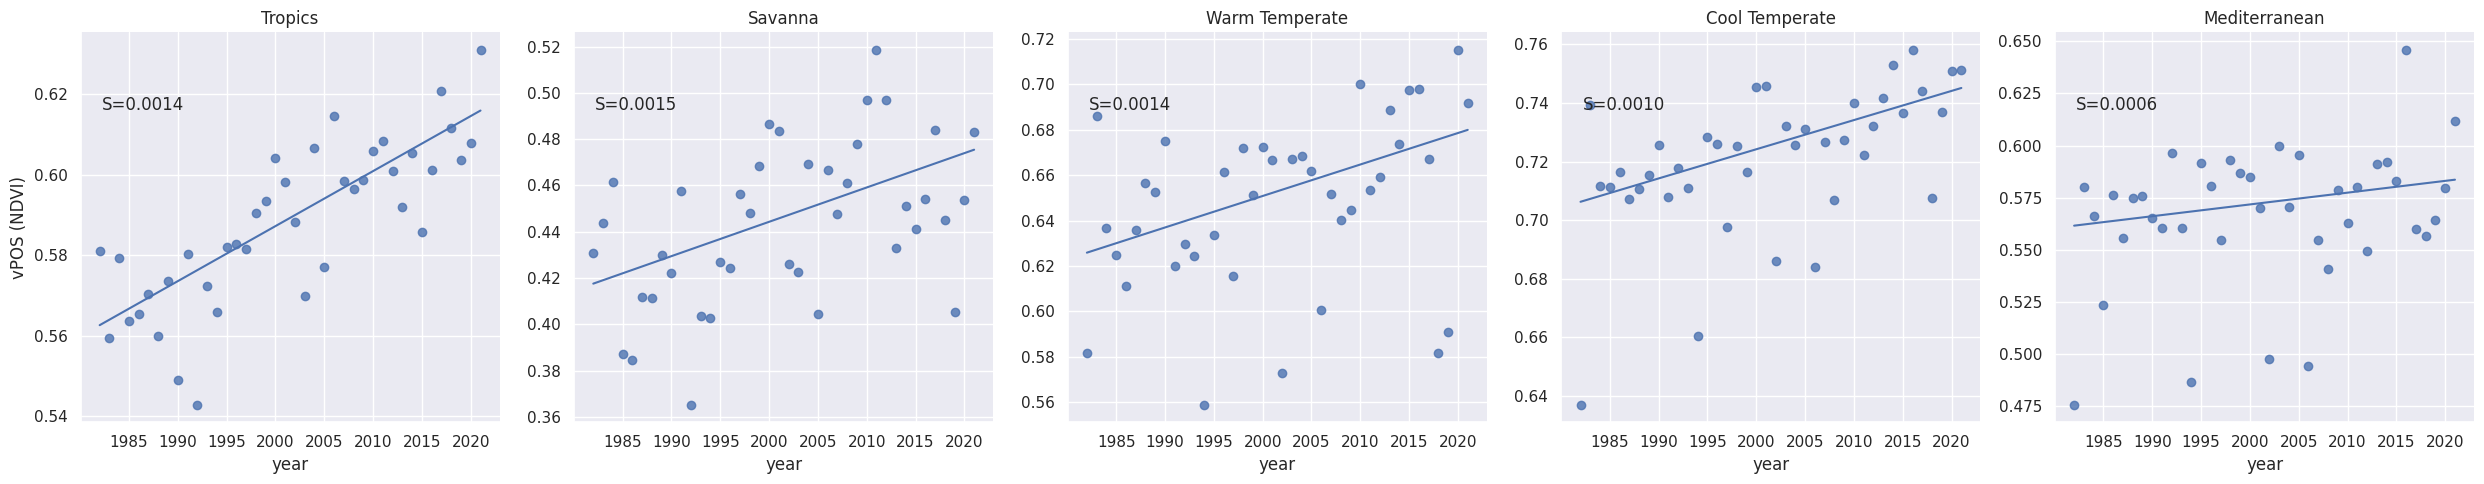

In [24]:
g = sb.lmplot(
    data=df.reset_index(), x="year", y="vPOS (NDVI)",
    col="region", col_wrap=5, fit_reg=False,
    facet_kws=dict(sharex=True, sharey=False)
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")
def annotate(data, **kws):
    # s, i, r, p, se = stats.linregress(data['year'],data['Peak-Of-Season (DOY)'])
    s, i, l, h =  stats.mstats.theilslopes(data['vPOS (NDVI)'], data['year']) 
    ax = plt.gca()
    ax.plot(data['year'], i + s * data['year'], 'b-')
    # ax.plot(data['year'], i + l * data['year'], 'r--')
    # ax.plot(data['year'], i + h * data['year'], 'r--')
    ax.text(.05, .8, 'S={:.4f}'.format(s),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)

#### The second way

In [25]:
pos_trends['trend'] = pos_trends['trend']*10

In [26]:
doy_var = [pos_trends, vpos_trends]
names = ['POS', 'vPOS']

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], ds.isel(time=1))
    mask = round_coords(mask)
    
    if var=='NDVI':
        mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(doy_var, names):
        var_region = v.where(mask)
        
        doy_df = var_region.drop('spatial_ref').to_dataframe()
        doy_df = doy_df[['trend', 'signif']]
        
        doy_df['region'] = row['region_name']
        doy_df = doy_df.rename({
            'trend':'trend_'+n,
            'signif':'signif_'+n,
                      }, axis=1)
        inner.append(doy_df)
    outer.append(inner)

trends_df=[]
for i in range(0,len(outer)):
    xx = trends_df.append(pd.concat(outer[i]))
trends_df = pd.concat(trends_df).reset_index(drop=True)

In [27]:
# trends_df['trend_POS'] = trends_df['trend_POS']

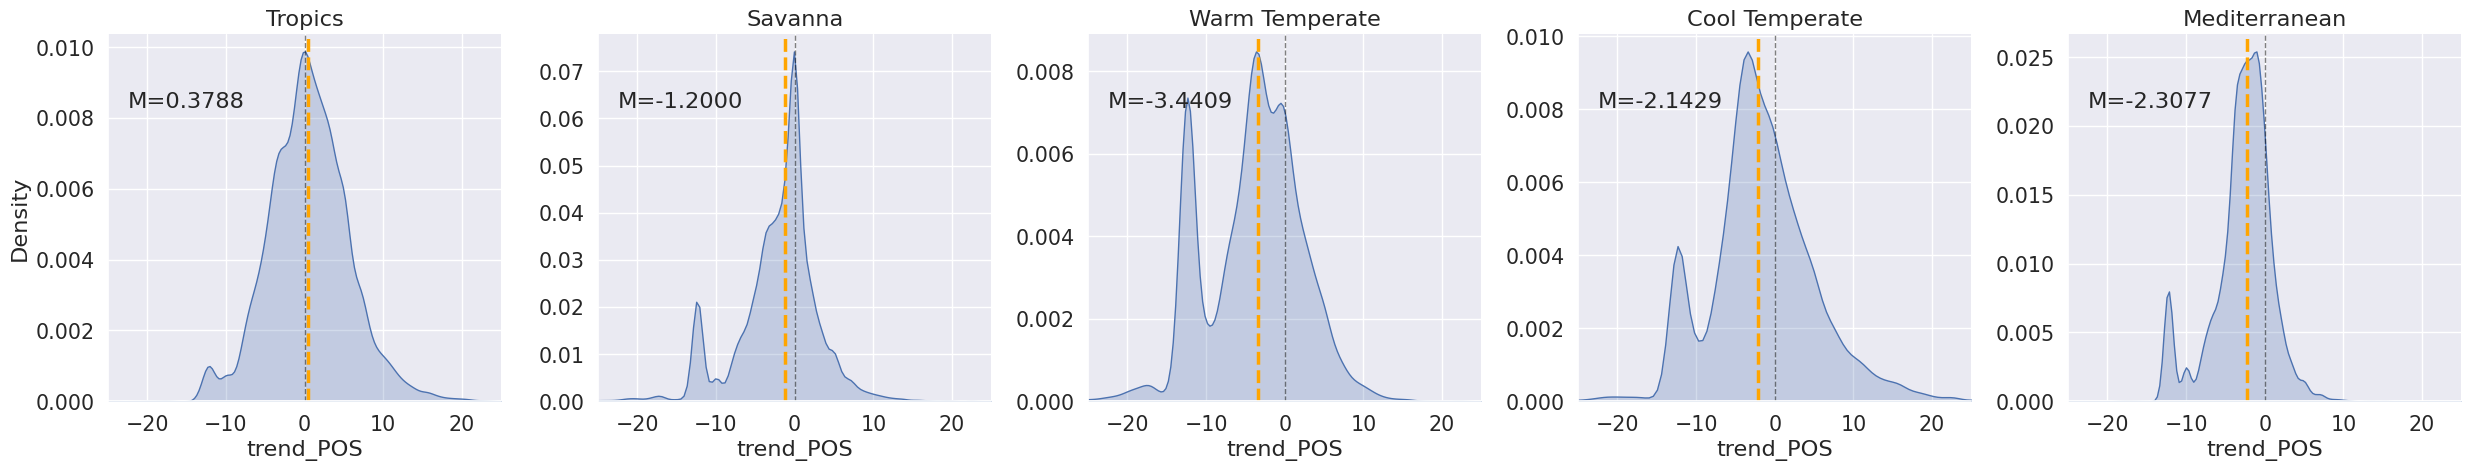

In [28]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_POS",
    col="region", col_wrap=5, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-25,25))
)

g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_POS")
g.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/POS_"+var+"_bioregion_dist.png",
          bbox_inches='tight', dpi=300);

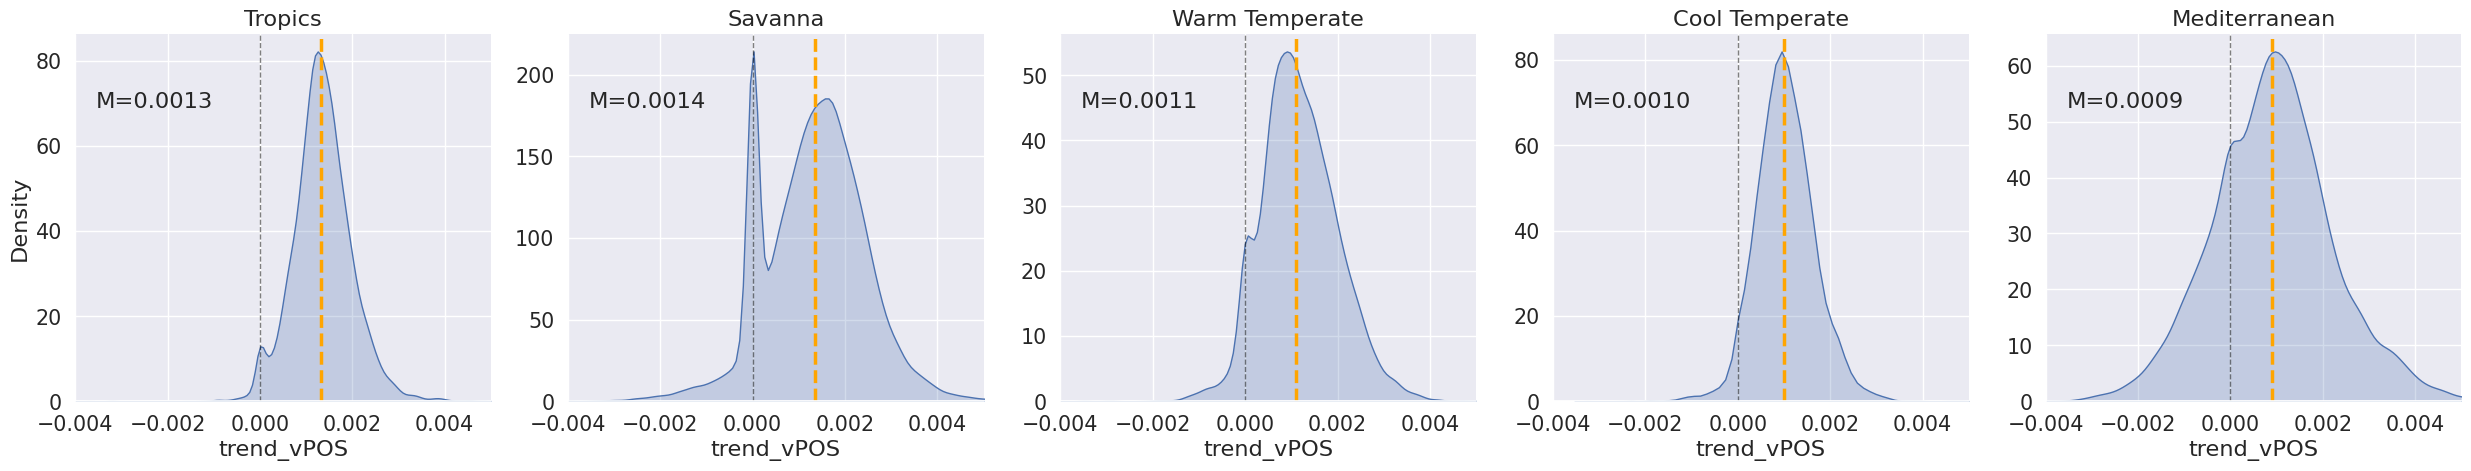

In [29]:
sb.set(font_scale=1.35)

g = sb.displot(trends_df, kind="kde", fill=True, x="trend_vPOS",
    col="region", col_wrap=5, palette='viridis',
    facet_kws=dict(sharex=True, sharey=False, xlim=(-0.004, 0.005))
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")

def specs(x, **kwargs):
    plt.axvline(0, c='black', ls='--', lw=1, alpha=0.5)
    plt.axvline(x.median(), c='orange', ls='--', lw=2.5)
    ax = plt.gca()
    ax.text(.05, .8, 'M={:.4f}'.format(x.median()),
            transform=ax.transAxes)

g.map(specs, "trend_vPOS")
g.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/vPOS_"+var+"_bioregion_dist.png",
          bbox_inches='tight', dpi=300);

## Phenology curves

### Per bioregion

In [30]:
_var = [ds_smooth]
names = [var]

outer = []
for index, row in gdf.iterrows():
    mask = xr_rasterize(gdf.iloc[[index]], ds.isel(time=1))
    mask = round_coords(mask)
    if var=='NDVI':
        mask = mask.rename({'latitude':'y', 'longitude':'x'})
    
    inner = []
    for v,n in zip(_var, names):
        ds.name=var
        ds_region = v.where(mask)
        
        early_clim = ds_region.sel(time=slice('1982', '2001')).groupby('time.month').mean()
        late_clim = ds_region.sel(time=slice('2002', '2022')).groupby('time.month').mean()
        
        df = early_clim.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        df['2002-2022'] = late_clim.mean(['x', 'y']).drop('spatial_ref').to_dataframe()
        df = df.rename({'NDVI':'1982-2001'}, axis=1)
        
        df['region'] = row['region_name']
        # df['Month'] = ["J","F","M","A","M","J","J","A","S","O","N","D"]
        
        inner.append(df)
    outer.append(inner)

dffs=[]
for i in range(0,len(outer)):
    dffs.append(pd.concat(outer[i]))
df_ds_clim = pd.concat(dffs)

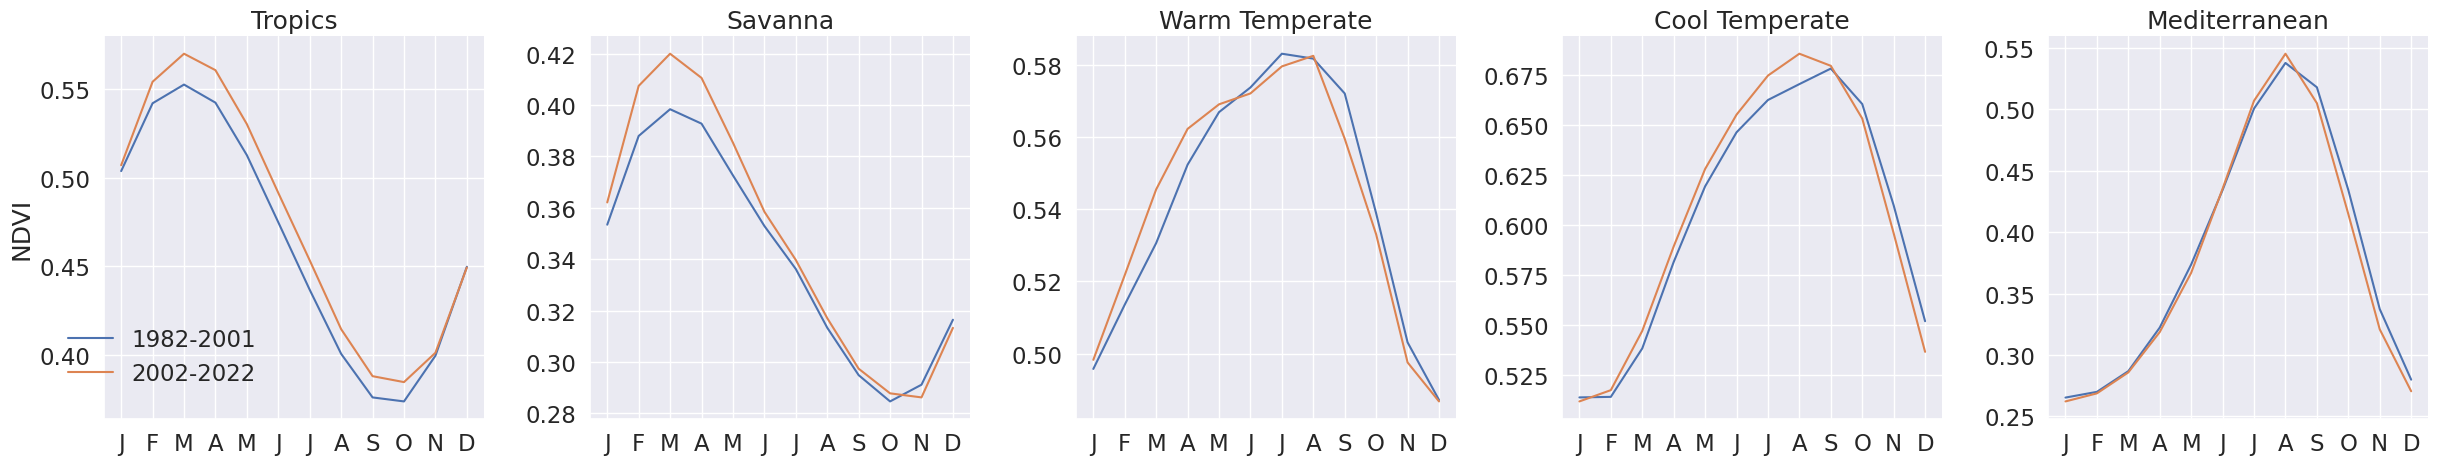

In [31]:
sb.set(font_scale=1.5)
g = sb.relplot(
    data=df_ds_clim.melt(id_vars='region', ignore_index=False, value_name=var, var_name='Climatology Range'),
    x="month",
    y=var,
    col="region",
    hue='Climatology Range',
    col_wrap=5, kind="line", ci=None,
    # palette=sb.color_palette("rocket_r"),
    facet_kws=dict(sharex=True, sharey=False)
)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
sb.move_legend(g, "upper center", 
    bbox_to_anchor=(.065, 0.35), ncol=1, title=None, frameon=False)
g.set(xlabel=None)
g.set(xticks=range(1,13))
g.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"]);
g.tight_layout();
g.savefig("/g/data/os22/chad_tmp/AusENDVI/results/figs/"+var+"_phenology_bioregion.png",
          bbox_inches='tight', dpi=300);

### Australian-wide

Ignoring the non-seasonal areas we masked

In [32]:
early_clim = ds_smooth.sel(time=slice('1982', '2001')).groupby('time.month').mean()
late_clim = ds_smooth.sel(time=slice('2002', '2022')).groupby('time.month').mean()

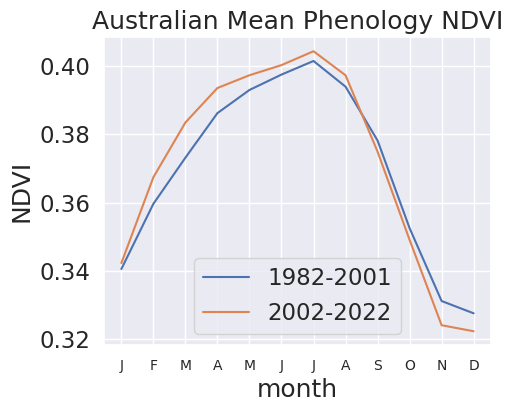

In [33]:
fig, ax = plt.subplots(1,1, figsize=(5,4))
early_clim.mean(['x','y']).plot(label='1982-2001', ax=ax)
late_clim.mean(['x','y']).plot(label='2002-2022', ax=ax)
ax.legend()
plt.title('Australian Mean Phenology '+var)
ax.set(xticks=range(1,13))
ax.set_xticklabels(["J","F","M","A","M","J","J","A","S","O","N","D"], fontsize=10);